<a href="https://colab.research.google.com/github/lcmolteberg/Machineoblig3/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignemnt 3
### Exercise-1: Training Deep Neural Network on MNIST

In [4]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 8.1 MB/s eta 0:00:00


In [5]:
import sys

assert sys.version_info >= (3, 7)

In [14]:
from packaging import version
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import EarlyStopping
from copy import deepcopy

In [8]:
# Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [9]:
# Dataset
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
train_set = datasets.MNIST("./data", train=True, transform=tfm, download=True)
test_set = datasets.MNIST("./data", train=False, transform=tfm, download=True)

# 1000 train and 200 test
n_train = 1000
n_test = 200

train_subset = Subset(train_set, np.arange(n_train))
test_subset = Subset(test_set, np.arange(n_test))

val_size = 200
train_size = n_train - val_size
train_subset, val_subset = random_split(
    train_subset, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False)
test_loader = DataLoader(test_subset, batch_size)

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.60MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 892kB/s]


In [10]:
# Model

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, 10)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.net(x)
        return x

model = DNN().to(device)


Epoch 01: Train 2.6711 | Val 1.0710
Epoch 02: Train 1.9150 | Val 0.8210
Epoch 03: Train 1.3624 | Val 0.6429
Epoch 04: Train 0.9742 | Val 0.5047
Epoch 05: Train 0.7070 | Val 0.5297
Epoch 06: Train 0.5107 | Val 0.5305
Epoch 07: Train 0.3802 | Val 0.5117
Epoch 08: Train 0.2903 | Val 0.5447


2025-11-01 21:27:16,660 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 09: Train 0.2197 | Val 0.5211
✅ Restored best weights (val_loss=0.5047)


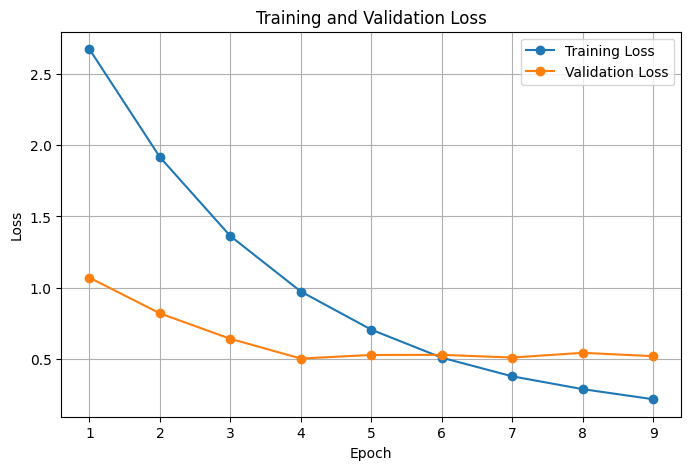

Test set — loss: 0.4565, accuracy: 0.8600
Final Test Accuracy: 86.00%


In [15]:
# Optimizer

optimizer = optim.NAdam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

best_state = {"best_val": float("inf"), "weights": None}


trainer = create_supervised_trainer(model, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(
    model, metrics={'accuracy': Accuracy(), 'loss': Loss(loss_fn)}, device=device
)

# --- enkel train-loss logging uten ekstra pass ---
RunningAverage(output_transform=lambda out: out).attach(trainer, "train_loss")

# --- EarlyStopping: høyere score = bedre, så returner -val_loss ---
def score_function(engine):
    return -engine.state.metrics['loss']

early_stop = EarlyStopping(patience=5, score_function=score_function, trainer=trainer)
# Viktig: kobles til EVALUATOR, og evaluator MÅ kjøres hver epoke
evaluator.add_event_handler(Events.COMPLETED, early_stop)

# --- historikk for plotting ---
train_losses, val_losses = [], []

@trainer.on(Events.EPOCH_COMPLETED)
def validate_and_log(engine):
    # Train loss fra RunningAverage ELLER beregn selv – beholder du din nåværende måte, bruk den
    train_loss = trainer.state.metrics['train_loss'] if 'train_loss' in trainer.state.metrics else None

    # Kjør validering (triggere EarlyStopping via evaluator-eventet)
    evaluator.run(val_loader)
    val_loss = evaluator.state.metrics['loss']

    # (valgfritt) hvis du ikke bruker RunningAverage: mål train loss med en egen evaluator-pass
    # evaluator.run(train_eval_loader); train_loss = evaluator.state.metrics['loss']

    train_losses.append(train_loss if train_loss is not None else float("nan"))
    val_losses.append(val_loss)

    # ---- SAVE BEST IN MEMORY (restore best weights) ----
    if val_loss < best_state["best_val"]:
        best_state["best_val"] = val_loss
        best_state["weights"] = deepcopy(model.state_dict())

    print(f"Epoch {engine.state.epoch:02d}: Train {train_loss:.4f} | Val {val_loss:.4f}")


# --- tren (ES kan stoppe før 50) ---
trainer.run(train_loader, max_epochs=50)
if best_state["weights"] is not None:
    model.load_state_dict(best_state["weights"])
    print(f"✅ Restored best weights (val_loss={best_state['best_val']:.4f})")

# --- plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
epochs = range(1, len(train_losses)+1)
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses,   marker='o', label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True); plt.show()

# --- test ---
evaluator.run(test_loader)
m = evaluator.state.metrics
print(f"Test set — loss: {m['loss']:.4f}, accuracy: {m['accuracy']:.4f}")
print(f"Final Test Accuracy: {m['accuracy']*100:.2f}%")


